In [1]:
import pandas as pd
df_BTC = pd.read_pickle('BTC-USD-60.pkl')

import datetime
from datetime import date
df_BTC['date'] = pd.to_datetime(df_BTC['time'],unit='s').dt.date
df_BTC['hour'] = pd.to_datetime(df_BTC['time'],unit='s').dt.hour

train_start_date = date(2016,1,1)
test_end_date = date(2018,4,3)
total_days = (test_end_date - train_start_date).days + 1
print(total_days)

df_BTC = df_BTC[df_BTC['date'] >= datetime.date(2016,1,1)]

group_BTC = df_BTC.groupby('date')

824


In [2]:
import numpy as np

# Extract 4 prices per day 
four_prices = group_BTC.apply(lambda x: x.iloc[::int(np.around(x.time.count()/4))].iloc[:4]).sort_values(by=['time'])

four_prices_mat = four_prices['close'].as_matrix().reshape((total_days, 4))
four_prices_mat

array([[ 436.12,  433.56,  432.2 ,  433.18],
       [ 437.03,  436.19,  433.92,  435.84],
       [ 433.52,  433.52,  427.55,  427.49],
       ...,
       [6991.89, 6718.  , 6513.  , 6827.99],
       [6939.  , 6978.  , 7013.  , 6922.99],
       [7206.56, 7355.63, 7374.99, 7321.  ]])

In [3]:
# sanity check: correct reshaping?  
four_prices.as_matrix()[:4]

array([[1451624340, 436.12, 436.13, 436.12, 436.12, 6.139053,
        datetime.date(2016, 1, 1), 4],
       [1451638620, 433.56, 434.01, 434.01, 433.56, 11.8782,
        datetime.date(2016, 1, 1), 8],
       [1451652720, 432.2, 432.21, 432.21, 432.2, 0.02,
        datetime.date(2016, 1, 1), 12],
       [1451665560, 433.11, 433.18, 433.11, 433.18, 0.3483,
        datetime.date(2016, 1, 1), 16]], dtype=object)

In [4]:
import sklearn.preprocessing
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))

In [5]:
import numpy as np

valid_set_size_percentage = 20 
test_set_size_percentage = 10 

# function to create train, validation, test data given sequence length
def load_data(data_raw, seq_len):
    
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
        
    transformed = scaler.fit_transform(data_raw)
    
    data_norm = []
    
    # create all possible sequences of length seq_len
    for index in range(len(transformed) - seq_len): 
        data_norm.append(transformed[index: index + seq_len])
    
    data = np.array(data);
    data_norm = np.array(data_norm);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data_norm[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data_norm[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data_norm[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# create train, test data
seq_len = 10 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(four_prices_mat, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (570, 9, 4)
y_train.shape =  (570, 4)
x_valid.shape =  (163, 9, 4)
y_valid.shape =  (163, 4)
x_test.shape =  (81, 9, 4)
y_test.shape =  (81, 4)


In [6]:
# shuffle training data
s = np.arange(x_train.shape[0])
np.random.shuffle(s)
x_train = x_train[s]
y_train = y_train[s]

In [7]:
def SMAPE(y, y_pred):
    if len(y) != len(y_pred):
        raise ValueError('Length of prediction array is not equal to length of y array.')
    return np.mean(np.abs(y-y_pred)*2/(np.abs(y)+np.abs(y_pred)))

# LSTM model graph

In [8]:
import tensorflow as tf

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], scaler.transform(y_train[perm_array[start:end]])

# parameters
n_steps = seq_len-1 
n_inputs = x_train.shape[-1]
n_neurons = 200  # cell.state_size
n_outputs = y_train.shape[-1]
n_layers = 1
learning_rate = 1e-4
batch_size = 50
n_epochs = 200 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
keep_prob = 0.8
max_gradient_norm = 10

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell
layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, \
                                  initializer=tf.contrib.layers.xavier_initializer(), \
                                  activation=tf.nn.elu)
         for layer in range(n_layers)]

# use Basic LSTM Cell 
# layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#           for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)

outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
outputs = tf.nn.dropout(outputs, keep_prob)

# 'outputs' is a tensor of shape [batch_size, n_steps, n_neurons(cell.state_size)]
stacked_outputs = tf.reshape(outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

#loss = tf.reduce_mean(tf.square(outputs/y-1)) # loss function = normalized mean squared error 
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
#loss = tf.reduce_mean(tf.abs(y-outputs)*2/(tf.abs(y)+tf.abs(outputs))) # SMAPE
params = tf.trainable_variables()
gradients = tf.gradients(loss, params)
gradient_norm = tf.global_norm(gradients)
clipped_gradients, _ = tf.clip_by_global_norm(gradients, max_gradient_norm)
clipped_norm = tf.global_norm(clipped_gradients)
param_norm = tf.global_norm(params)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate) 
# training_op = optimizer.minimize(loss)
training_op = optimizer.apply_gradients(zip(clipped_gradients, params))

# initialize parameters
sess = tf.Session()
global_step = tf.Variable(0, name='global_step', trainable=False)
saver = tf.train.Saver(max_to_keep=2)

/Users/kexinyu/anaconda3/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


Instructions for updating:
Use the retry module or similar alternatives.


In [9]:
experiment_name = 'LSTM_4_points' # type your experiment name here before running the code below

In [ ]:
# run graph
ckpt = tf.train.get_checkpoint_state(experiment_name)
v2_path = ckpt.model_checkpoint_path + ".index" if ckpt else ""
if ckpt and (tf.gfile.Exists(ckpt.model_checkpoint_path) or tf.gfile.Exists(v2_path)):
#     iteration = tf.get_variable('iteration',[1])
    saver.restore(sess, ckpt.model_checkpoint_path)
    iteration = global_step.eval(session=sess) # get last global_step
    print("Start from iteration:", iteration)
else:
    print('There is not saved parameters. Creating model with fresh parameters.')
#     iteration = tf.get_variable('iteration',[1], initializer = tf.zeros_initializer)
    sess.run(tf.global_variables_initializer())
    iteration = 0
#     sess.run(iteration)
    
while True:
    iteration = iteration + 1
    x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
     
    # output_feed contains the things we want to fetch.
    output_feed = [training_op, loss, param_norm]
    [_, loss_val, param_norm_val] \
        = sess.run(output_feed, feed_dict={X: x_batch, y: y_batch})
    
    if iteration % int(50*train_set_size/batch_size) == 0:
#             loss_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
#             loss_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
        y_train_pred = scaler.inverse_transform(sess.run(outputs, feed_dict={X: x_train}))
        y_valid_pred = scaler.inverse_transform(sess.run(outputs, feed_dict={X: x_valid}))
        print('%.2f epochs: loss = %.7f, param_norm = %.3f, SMAPE train/valid = %.6f/%.6f' \
              %(iteration*batch_size/train_set_size, loss_val, param_norm_val, \
                SMAPE(y_train, y_train_pred), \
                SMAPE(y_valid, y_valid_pred)))
#             print('%.2f epochs: loss train/valid = %.6f/%.6f'%(
#                 iteration*batch_size/train_set_size, loss_train, loss_valid))
    if iteration % int(100*train_set_size/batch_size) == 0:
        global_step.assign(iteration).eval(session=sess) # set and update(eval) global_step with index, i
        save_path = saver.save(sess, "./"+experiment_name+"/model.ckpt", global_step=global_step)
        print('Saved parameters to %s' % save_path)

y_train_pred = sess.run(outputs, feed_dict={X: x_train})
y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
y_test_pred = sess.run(outputs, feed_dict={X: x_test})

INFO:tensorflow:Restoring parameters from LSTM_4_points/model.ckpt-267900
Start from iteration: 267900
23550.00 epochs: loss = 0.0000043, param_norm = 18.597, SMAPE train/valid = 0.029681/0.041457
23600.00 epochs: loss = 0.0000071, param_norm = 18.597, SMAPE train/valid = 0.030417/0.041335
Saved parameters to ./LSTM_4_points/model.ckpt-269040
23650.00 epochs: loss = 0.0000040, param_norm = 18.597, SMAPE train/valid = 0.029918/0.041723
23700.00 epochs: loss = 0.0000144, param_norm = 18.597, SMAPE train/valid = 0.031945/0.040864
Saved parameters to ./LSTM_4_points/model.ckpt-270180
23750.00 epochs: loss = 0.0000091, param_norm = 18.597, SMAPE train/valid = 0.033286/0.044238
23800.00 epochs: loss = 0.0000094, param_norm = 18.597, SMAPE train/valid = 0.029587/0.043213
Saved parameters to ./LSTM_4_points/model.ckpt-271320
23850.00 epochs: loss = 0.0000052, param_norm = 18.597, SMAPE train/valid = 0.029433/0.040971


In [24]:
y_test_pred = scaler.inverse_transform(sess.run(outputs, feed_dict={X: x_test}))
SMAPE(y_test, y_test_pred)

0.046616115639572735

correct sign prediction for close - open price for train/valid/test: 0.48/0.53/0.43


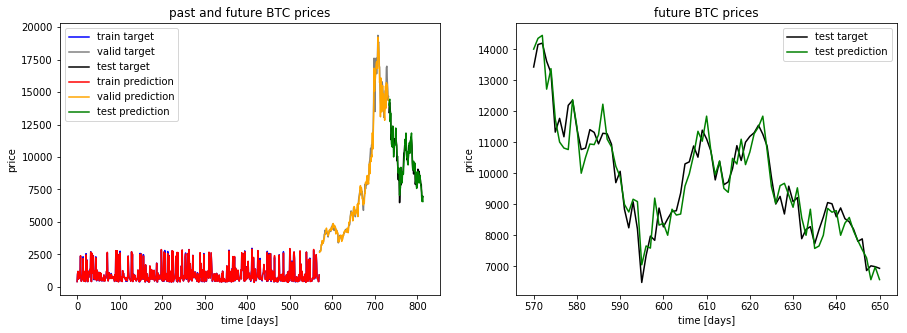

In [26]:
import matplotlib.pyplot as plt

ft = 0 

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future BTC prices')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future BTC prices')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))